# HMK 2

Paul Conerardy
11206073


---





This notebook will only presents the model that offered me the best performance on Kaggle but a few more were tried.

The final model used is SciBERT (cf: https://www.aclweb.org/anthology/D19-1371.pdf) which is a pretrained language model based on BERT that was specifically trained on a corpus of scientific texts.

The model is adjusted using the library "transformers" by HuggingFace. The title of the paper will be concatenated with its abstract and then go through a few trasnformations. The text will be cleaned by removing any URLs, hashtags, non-alphanumeric characters, etc... but also any stopwords (words without any semantic meaning). The idea behind this transformation is to focus on the vocabulary specific to each scientific field that we have to classify. 

Since the distribution of the different labels is very unbalanced (displayed at the end of this notebook), a weighting will be applied when computing the cross entropy loss. Those weightings were empirically chosen after a few tries. 

Moreover, since BERT is a lot less complex than other modern transformer models (like RoBERTa) this allows us to try to maximize the maximum sequence length of text considered for each observation since we are still limited VRAM-wise.

Finally, since our dataset is relatively small (60k observations) and after finding an acceptable configuration, I tried to use the dataset almost entirely for training (keeping only 5% for validation and no test set) to try to maximize my performance on Kaggle.

In [ ]:
!pip install transformers
!pip install sentencepiece
import pandas as pd
import numpy as np
import random

import pandas as pd
import numpy as np
import os
import random
import networkx as nx

from tensorflow import keras
import torch

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

     |████████████████████████████████| 2.0MB 3.9MB/s 
     |████████████████████████████████| 3.2MB 51.2MB/s 
     |████████████████████████████████| 890kB 48.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=77298e726de4b89764c3dbe3e393af8c7dc03acf9da3c693d47f12a6472e42db
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 5.8MB/s 


In [ ]:
import torch

# GPU runtime
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU used:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU used: Tesla V100-SXM2-16GB


# Data Loading

In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/Colab Notebooks/ML2/Hmk2/data'

train = pd.read_csv(path + "/train.csv", names=["label", "node idx"])
test = pd.read_csv(path + "/test.csv", names=["node idx"])
text = pd.read_csv(path + "/text.csv", names=["paper id", "title", "abstract"])

node2paper = pd.read_csv(path + "/nodeid2paperid.csv")
sample = pd.read_csv(path + "/sample.csv")  

# Tokenization

In [ ]:
# Data merging to link the ids and the text

reference = node2paper

df = pd.merge(train, reference, on="node idx")
df = pd.merge(df, text, on = "paper id")

print('Number of observations: {:,}\n'.format(df.shape[0]))

df.head(5)

Number of observations: 60,000



,label,node idx,paper id,title,abstract
0,4,0,9657784,evasion attacks against machine learning at te...,"In security-sensitive applications, the succes..."
1,5,1,39886162,how hard is computing parity with noisy commun...,We show a tight lower bound of $\Omega(N \log\...
2,8,3,121432379,a promise theory perspective on data networks,Networking is undergoing a transformation thro...
3,6,6,1444859417,webvrgis based city bigdata 3d visualization a...,This paper shows the WEBVRGIS platform overlyi...
4,4,7,1483430697,information theoretic authentication and secre...,"In the splitting model, information theoretic ..."


In [ ]:
# Concatenation of the paper's title and abstract and conversion to arrays

df['text'] = df['title'] + ' ' +df['abstract']


In [ ]:
def clean_text(text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [ ]:
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [ ]:
df.head()

,label,node idx,paper id,title,abstract,text
0,4,0,9657784,evasion attacks against machine learning at te...,"In security-sensitive applications, the succes...",evasion attacks against machine learning at te...
1,5,1,39886162,how hard is computing parity with noisy commun...,We show a tight lower bound of $\Omega(N \log\...,how hard is computing parity with noisy commun...
2,8,3,121432379,a promise theory perspective on data networks,Networking is undergoing a transformation thro...,a promise theory perspective on data networks ...
3,6,6,1444859417,webvrgis based city bigdata 3d visualization a...,This paper shows the WEBVRGIS platform overlyi...,webvrgis based city bigdata 3d visualization a...
4,4,7,1483430697,information theoretic authentication and secre...,"In the splitting model, information theoretic ...",information theoretic authentication and secre...


In [ ]:
# We create a column with no stopwords and "clean" text

df['text'] = clean_text(df['text'])
df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#df["text"] = df["text"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() ]))
df["text"] = clean_text(df["text"])

In [ ]:
df['text'].head()

0    evasion attacks machine learning test time sec...
1    hard computing parity noisy communications sho...
2    promise theory perspective data networks netwo...
3    webvrgis based city bigdata 3d visualization a...
4    information theoretic authentication secrecy c...
Name: text, dtype: object

In [ ]:
text = df.text.values
labels = df.label.values

In [ ]:
# Instantiate the tokenizer (SciBERT)
# List of pretrained models : https://huggingface.co/transformers/pretrained_models.html


from transformers import DebertaV2Tokenizer, RobertaTokenizer, AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased',do_lower_case=True)

In [ ]:
# Test of the tokenization process
print('Original sentence: ', text[0])
print('Tokenized sentence: ', tokenizer.tokenize(text[0]))
print('Tokens IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[0])))

Original sentence:  evasion attacks machine learning test time security sensitive applications success machine learning depends thorough vetting resistance adversarial data one pertinent well motivated attack scenario adversary may attempt evade deployed system test time carefully manipulating attack samples work present simple effective gradient based approach exploited systematically assess security several widely used classification algorithms evasion attacks following recently proposed framework security evaluation simulate attack scenarios exhibit different risk levels classifier increasing attacker's knowledge system ability manipulate attack samples gives classifier designer better picture classifier performance evasion attacks allows perform informed model selection (or parameter setting) evaluate approach relevant security task malware detection pdf files show systems easily evaded also sketch countermeasures suggested analysis
Tokenized sentence:  ['ev', '##asion', 'attacks',

In [ ]:
inputs_id = []

# Loop to tokenize the dataset
for t in text:
  encoded_sent = tokenizer.encode(t,
                                  add_special_tokens=True)
  
  inputs_id.append(encoded_sent)

print('Original sentence: ', text[0])
print(' Tokens IDs:', inputs_id[0])

Original sentence:  evasion attacks machine learning test time security sensitive applications success machine learning depends thorough vetting resistance adversarial data one pertinent well motivated attack scenario adversary may attempt evade deployed system test time carefully manipulating attack samples work present simple effective gradient based approach exploited systematically assess security several widely used classification algorithms evasion attacks following recently proposed framework security evaluation simulate attack scenarios exhibit different risk levels classifier increasing attacker's knowledge system ability manipulate attack samples gives classifier designer better picture classifier performance evasion attacks allows perform informed model selection (or parameter setting) evaluate approach relevant security task malware detection pdf files show systems easily evaded also sketch countermeasures suggested analysis
 Tokens IDs: [102, 403, 22591, 7652, 3997, 1904, 

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 350
# Sequence padding to get sequences of size MAX_LEN
inputs_id = pad_sequences(inputs_id, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [ ]:
# Attention mask to not consider padding ids in the model introduced just above

attention_masks = []

for sentence in inputs_id:
  att_mask = [int(token_id > 0) for token_id in sentence]
  attention_masks.append(att_mask)

In [ ]:
# Data splits

from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(inputs_id, labels,
                                                                                   random_state=42, test_size=0.05)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.05)

# Data to pytorch

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Batch_size will be selected to maximize the sequence length selected earlier while still being able to fit everything in memory
batch_size = 20

# Training DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Test DataLoader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW


class SciBERT(torch.nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(SciBERT, self).__init__()
        
        self.roberta = AutoModelForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=768, return_dict=False, output_hidden_states = False,output_attentions = False) # Change?   :  RobertaForSequenceClassification + add linear layers ?
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64) 
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 20)
        
    def forward(self, input_ids, attention_mask):
        x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]
        # print(x)
        # print(x.shape())
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x

In [ ]:
model = SciBERT()
model = model.to(device)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

# Optimizer

In [ ]:
# Adam Optimizer with Weight Decay

optimizer = AdamW(model.parameters(),
                  lr = 1e-5, 
                  eps = 1e-8) 

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 12

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# Scoring function

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

# Function to get an idea of training time

def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training Loop

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    t0 = time.time()
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Print current training time and batch every 200 batch done
        if step % 200 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack the inputs from our dataloader and attach them to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        # Forward pass
        outputs = model(b_input_ids, 
                    #token_type_ids=None, 
                    attention_mask=b_input_mask
                    #, labels=b_labels
                    )
        
        weights = [1, 1.5, 1, 1, 1, 1, 1, 1.5, 1, 1, 1, 2, 1.5, 1, 1, 1, 0.6, 1, 1, 1]
        class_weights = torch.FloatTensor(weights).cuda()
        loss = torch.nn.CrossEntropyLoss(weight = class_weights)(outputs, b_labels)
        total_loss += loss.item()
        # Backward pass
        loss.backward()

        # Clip the gradients to avoid "exploding" gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update optimizer and learning rate
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)               
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


              # Validation
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Model set to evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        # Move batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the current batch 
        b_input_ids, b_input_mask, b_labels = batch
        
        # Not computing gradients during validation
        with torch.no_grad():        

            # Forward pass
            outputs = model(b_input_ids, 
                            #token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Store the probabilities per class outputed by Roberta
        logits = outputs#[0]

        # Detach output from GPU 
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Call to the scoring function
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy

        # Track training steps
        nb_eval_steps += 1

    # Accuracy score obtained and time necessary to perform one epoch 
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("\n")

======== Epoch 1 / 12 ========
  Batch   200  of  2,850.    Elapsed: 0:01:19.
  Batch   400  of  2,850.    Elapsed: 0:02:39.
  Batch   600  of  2,850.    Elapsed: 0:03:59.
  Batch   800  of  2,850.    Elapsed: 0:05:18.
  Batch 1,000  of  2,850.    Elapsed: 0:06:38.
  Batch 1,200  of  2,850.    Elapsed: 0:07:57.
  Batch 1,400  of  2,850.    Elapsed: 0:09:17.
  Batch 1,600  of  2,850.    Elapsed: 0:10:37.
  Batch 1,800  of  2,850.    Elapsed: 0:11:56.
  Batch 2,000  of  2,850.    Elapsed: 0:13:16.
  Batch 2,200  of  2,850.    Elapsed: 0:14:35.
  Batch 2,400  of  2,850.    Elapsed: 0:15:55.
  Batch 2,600  of  2,850.    Elapsed: 0:17:15.
  Batch 2,800  of  2,850.    Elapsed: 0:18:34.

  Average training loss: 1.15
  Training epcoh took: 0:18:54

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:19


======== Epoch 2 / 12 ========
  Batch   200  of  2,850.    Elapsed: 0:01:20.
  Batch   400  of  2,850.    Elapsed: 0:02:39.
  Batch   600  of  2,850.    Elapsed: 0:03:59.
  Batch 

# Preparing the dataset for prediction

In [ ]:

test = pd.read_csv(path + "/test.csv", names=["node idx"])
text = pd.read_csv(path + "/text.csv", names=["paper id", "title", "abstract"])

# Same treatment as the training dataset
test = pd.merge(test, reference, on="node idx")
test = pd.merge(test, text, on = "paper id")

df = test
df['text'] = df['title'] + ' ' +df['abstract']

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

titles_test = df.text.values

# Call to the same tokenizer as the training set
input_ids = []

for t in titles_test:

    encoded_sent = tokenizer.encode(
                        t,                   
                        add_special_tokens = True
                   )
    
    input_ids.append(encoded_sent)

# Padding
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
# Attention mask
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# To pytorch tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32  

# Pytorch dataLoader
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 13,718



# Predictions and submission file

In [ ]:
# Model set to evaluation mode
model.eval()

predictions = []

# Predict
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch
  
  # Not computing gradients during testing
  with torch.no_grad():
      outputs = model(b_input_ids,# token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs

  # Detach outputed results from GPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  
# Argmax on the outputed probabilities to find the chosen label
predictions_test = []
for i in range(len(predictions)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  predictions_test.append(pred_labels_i)

In [ ]:
# Predicted labels formatted into a single list
flat_list = []
for sublist in predictions_test:
    for item in sublist:
        flat_list.append(item)

In [ ]:
# Load the initial file and append the predictions
verif = pd.read_csv(path +'/test.csv', names=['id'])
flat_list = list(map(int, flat_list))
verif['label'] = flat_list

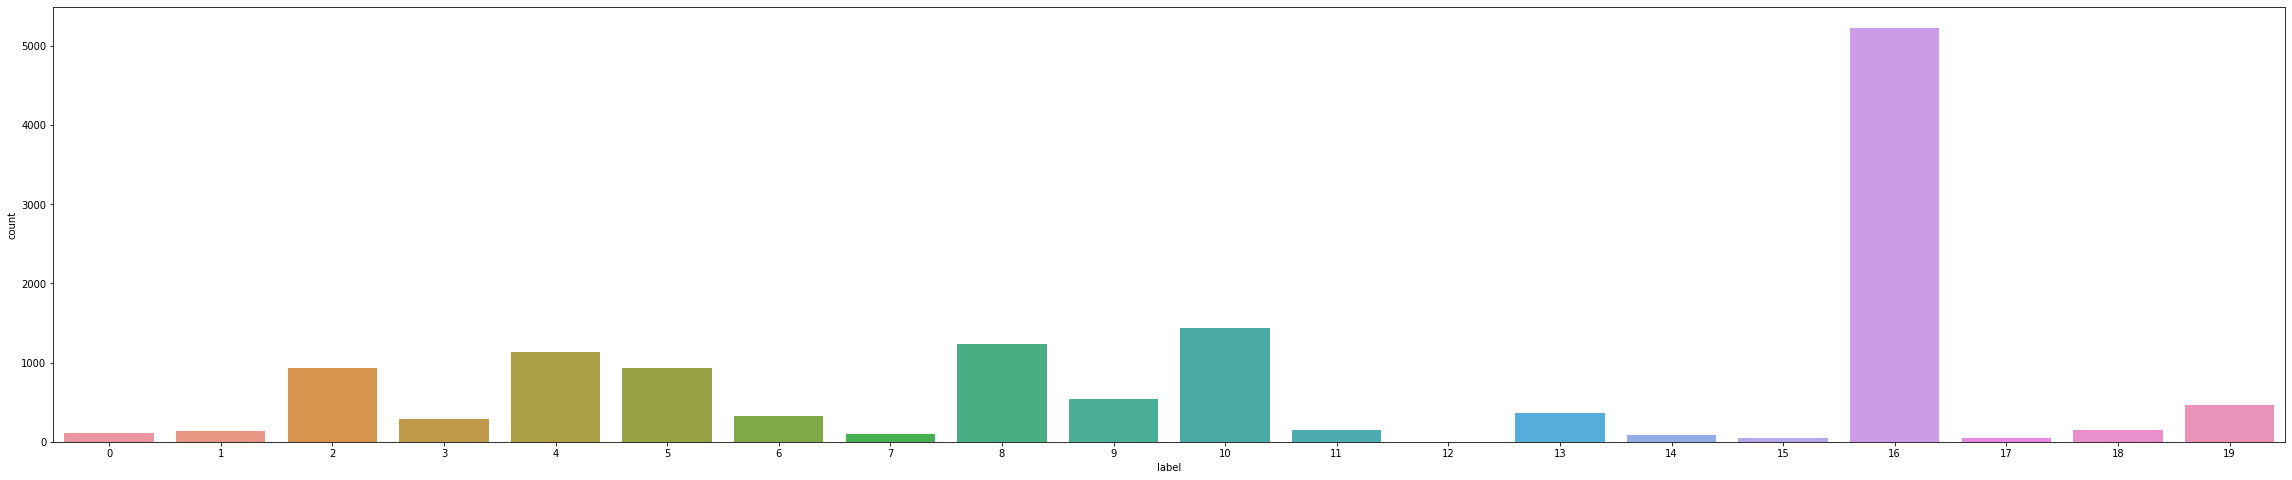

In [ ]:
# Verify the distribution of predicted labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40, 8))
sns.countplot(x='label', data=verif)
plt.show()

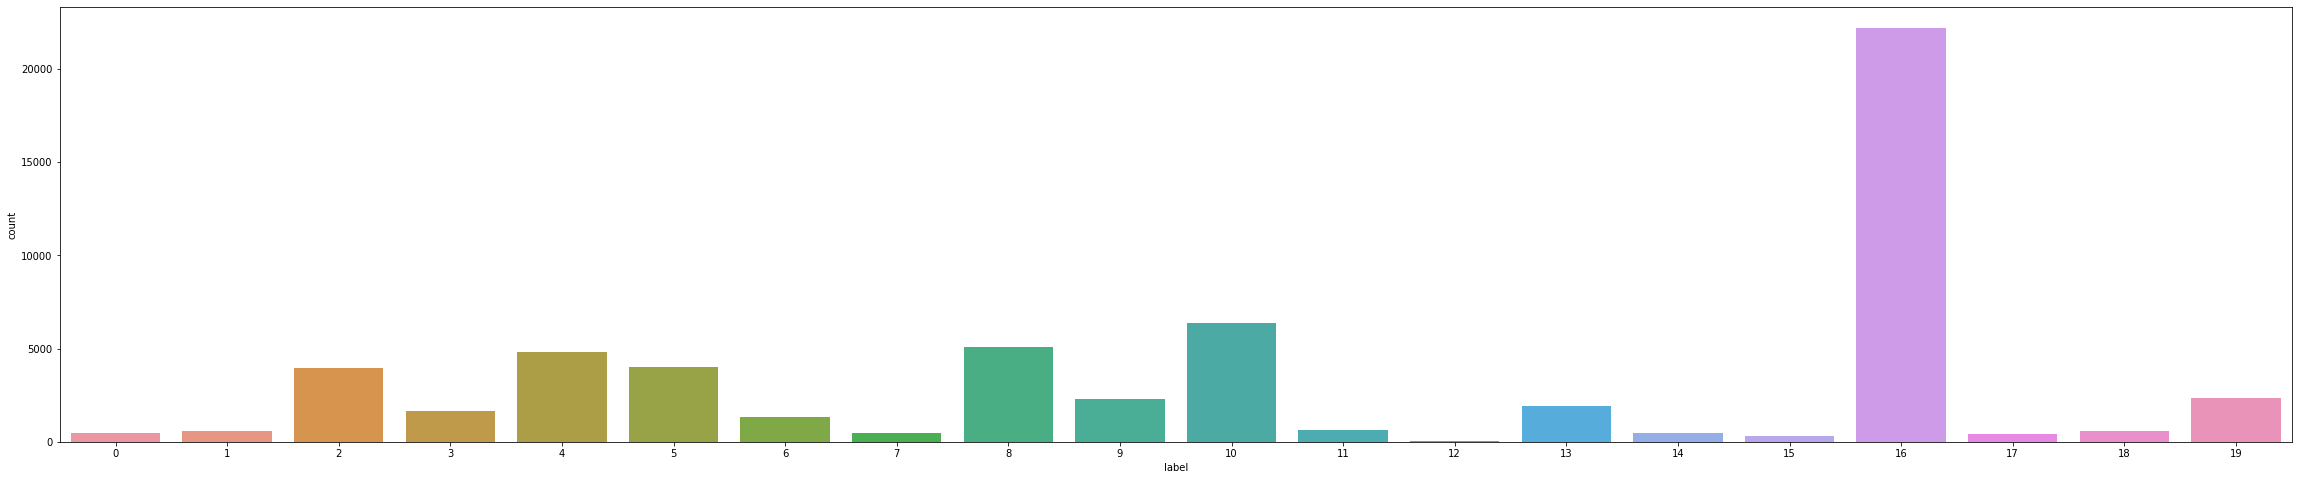

In [ ]:
# Can compare it to the distribution of labels in the training set
plt.figure(figsize=(40, 8))
sns.countplot(x='label', data=train)
plt.show()

In [ ]:
# Save the submission file in a format that Kaggle will accept
verif.to_csv('sub_SciBERT.csv', index=False)

In [ ]:
verif.head()

,id,label
0,137832,16
1,137833,4
2,137834,10
3,137836,5
4,137837,0
